In [1]:
from datasets import load_from_disk
processed_dataset = load_from_disk("processed_data")

In [ ]:
import torch
def collate_fn(batch):
    images = torch.stack([
        torch.stack([
            torch.tensor(row, dtype=torch.float32) for row in item["image"]
        ], dim=1).permute(2, 0, 1)
        for item in batch
    ])

    labels = torch.tensor([item["label"] for item in batch], dtype=torch.long)

    return {"image": images, "label": labels}

In [2]:
import os
base_path = "./data"

train_dataset = torch.load(os.path.join(base_path, "train.pt"))
val_dataset = torch.load(os.path.join(base_path, "val.pt"))
test_dataset = torch.load(os.path.join(base_path, "test.pt"))

In [7]:
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=4,
    pin_memory=True,
    prefetch_factor=2,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=4,
    pin_memory=True,
    prefetch_factor=2,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=4,
    pin_memory=True,
    prefetch_factor=2,
)

Train Label Distribution: Counter({12: 2566, 21: 2109, 23: 1379, 9: 1323, 20: 1267, 24: 890, 3: 851, 4: 833, 0: 546, 17: 502, 15: 473, 7: 439, 22: 410, 5: 318, 19: 291, 8: 274, 11: 264, 14: 262, 13: 251, 26: 229, 10: 183, 18: 101, 6: 94, 16: 62, 25: 42, 2: 22, 1: 19})
Validation Label Distribution: Counter({12: 320, 21: 264, 23: 173, 9: 166, 20: 158, 24: 111, 3: 107, 4: 104, 0: 69, 17: 62, 15: 59, 7: 55, 22: 51, 5: 39, 19: 37, 8: 34, 14: 33, 11: 33, 13: 31, 26: 28, 10: 23, 6: 12, 18: 12, 16: 8, 25: 6, 1: 3, 2: 2})
Test Label Distribution: Counter({12: 321, 21: 263, 23: 172, 9: 165, 20: 159, 24: 111, 3: 106, 4: 104, 0: 68, 17: 63, 15: 59, 7: 55, 22: 52, 5: 40, 19: 36, 8: 34, 11: 33, 14: 33, 13: 32, 26: 29, 10: 23, 18: 13, 6: 12, 16: 7, 25: 5, 2: 3, 1: 2})


In [8]:
from transformers import ViTForImageClassification
import torch

num_styles = len(set(processed_dataset["label"]))

model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k", 
    num_labels=num_styles
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_

In [9]:
from torch import nn
from torch.optim import AdamW

criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=5e-5)

In [10]:
import time

best_val_accuracy = 0.0
best_model_state = None

for epoch in range(10):
    model.train()
    start = time.time()
    train_loss = 0
    train_correct = 0
    total_train = 0
    print(f"Epoch {epoch+1}")
    for batch in train_loader:
        images = batch["image"].clone().permute(0, 3, 1, 2).to(device)
        labels = batch["label"].clone().detach().to(device)

        optimizer.zero_grad()
        outputs = model(pixel_values=images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * labels.size(0)
        _, preds = torch.max(outputs, dim=1)
        train_correct += torch.sum(preds == labels).item()
        total_train += labels.size(0)

    train_loss /= total_train
    train_accuracy = 100 * train_correct / total_train
    print(f"Training Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%, Elapsed time: {(time.time() - start)/60:.2f} minutes")

    model.eval()
    val_loss = 0
    val_correct = 0
    total_val = 0
    with torch.no_grad():
        for batch in val_loader:
            images = batch["image"].clone().permute(0, 3, 1, 2).to(device)
            labels = batch["label"].clone().detach().to(device)

            outputs = model(pixel_values=images).logits
            loss = criterion(outputs, labels)

            val_loss += loss.item() * labels.size(0)
            _, preds = torch.max(outputs, dim=1)
            val_correct += torch.sum(preds == labels).item()
            total_val += labels.size(0)

    val_loss /= total_val
    val_accuracy = 100 * val_correct / total_val
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_state = model.state_dict()
        torch.save(best_model_state, "best_vit.pth")
    torch.cuda.empty_cache()
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%, Elapsed time: {(time.time() - start)/60:.2f} minutes")
model.load_state_dict(torch.load("best_vit.pth"))

Epoch 1
Training Loss: 2.2519, Accuracy: 34.54%, Elapsed time: 9.67 minutes
Validation Loss: 1.9003, Validation Accuracy: 43.15%, Elapsed time: 10.41 minutes
Epoch 2
Training Loss: 1.5299, Accuracy: 53.74%, Elapsed time: 9.70 minutes
Validation Loss: 1.6373, Validation Accuracy: 47.65%, Elapsed time: 10.43 minutes
Epoch 3
Training Loss: 1.0175, Accuracy: 69.62%, Elapsed time: 9.70 minutes
Validation Loss: 1.5483, Validation Accuracy: 50.95%, Elapsed time: 10.43 minutes
Epoch 4
Training Loss: 0.5647, Accuracy: 84.84%, Elapsed time: 9.72 minutes
Validation Loss: 1.7310, Validation Accuracy: 48.40%, Elapsed time: 10.42 minutes
Epoch 5
Training Loss: 0.2923, Accuracy: 92.59%, Elapsed time: 9.72 minutes
Validation Loss: 1.8847, Validation Accuracy: 49.60%, Elapsed time: 10.42 minutes
Epoch 6
Training Loss: 0.1768, Accuracy: 95.75%, Elapsed time: 9.71 minutes
Validation Loss: 1.9637, Validation Accuracy: 50.35%, Elapsed time: 10.43 minutes
Epoch 7
Training Loss: 0.1218, Accuracy: 97.18%, Ela

<All keys matched successfully>

Uncomment and run if kernel restarted, and the model needs to be loaded in again.

In [8]:
# import torch
# from transformers import ViTForImageClassification
# import torch.nn as nn

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# num_styles = len(set(processed_dataset["label"]))

# model = ViTForImageClassification.from_pretrained(
#     "google/vit-base-patch16-224-in21k", 
#     num_labels=num_styles
# )

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.load_state_dict(torch.load("best_vit.pth"))
# model.to(device)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_

In [ ]:
# from torch.utils.data import DataLoader

# def collate_fn(batch):
#     images = torch.stack([
#         torch.stack([
#             torch.tensor(row, dtype=torch.float32) for row in item["image"]
#         ], dim=1).permute(2, 0, 1)
#         for item in batch
#     ])

#     labels = torch.tensor([item["label"] for item in batch], dtype=torch.long)

#     return {"image": images, "label": labels}

# test_dataset = torch.load("./data/test.pt")

# test_loader = DataLoader(
#     test_dataset, 
#     batch_size=32, 
#     shuffle=True, 
#     collate_fn=collate_fn, 
#     num_workers=4,
#     pin_memory=True, prefetch_factor=2
# )

Test Accuracy: 53.45%


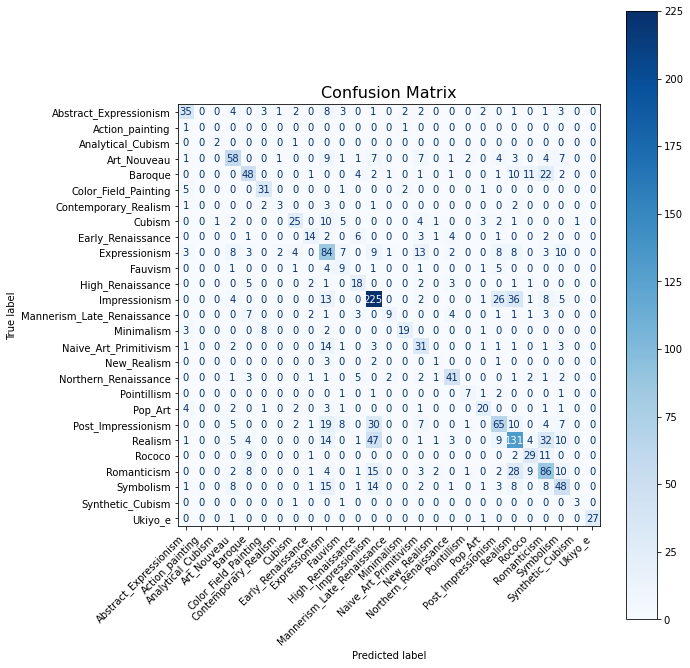

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy
import json

true_labels = []
predicted_labels = []

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for batch in test_loader:
        images = batch["image"].clone().permute(0, 3, 1, 2).to(device)
        labels = batch["label"].clone().detach().to(device)
        
        outputs = model(images)
        
        logits = outputs.logits
        _, preds = torch.max(logits, 1)
        
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())
        
        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

with open("num_to_style.json", "r") as f:
    num_to_style = json.load(f)

cm = confusion_matrix(true_labels, predicted_labels)

fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[num_to_style[str(i)] for i in range(len(num_to_style))])
disp.plot(cmap=plt.cm.Blues, ax=ax)

plt.title("Confusion Matrix", fontsize=16)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [12]:
from sklearn.metrics import classification_report

class_names = [num_to_style[str(i)] for i in range(len(num_to_style))]

report = classification_report(
    true_labels, 
    predicted_labels, 
    target_names=class_names, 
    digits=4
)
print(report)

                            precision    recall  f1-score   support

    Abstract_Expressionism     0.6250    0.5147    0.5645        68
           Action_painting     0.0000    0.0000    0.0000         2
         Analytical_Cubism     0.6667    0.6667    0.6667         3
               Art_Nouveau     0.5631    0.5472    0.5550       106
                   Baroque     0.5455    0.4615    0.5000       104
      Color_Field_Painting     0.6889    0.7750    0.7294        40
      Contemporary_Realism     0.4286    0.2500    0.3158        12
                    Cubism     0.6579    0.4545    0.5376        55
         Early_Renaissance     0.5833    0.4118    0.4828        34
             Expressionism     0.4000    0.5091    0.4480       165
                   Fauvism     0.2368    0.3913    0.2951        23
          High_Renaissance     0.4500    0.5455    0.4932        33
             Impressionism     0.6285    0.7009    0.6627       321
Mannerism_Late_Renaissance     0.6923    0.2812

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
